Stages:

A. Fetch and process data

B. Define initial model

C-1. Tuning hyperparameters 1

D-1. Selecting features 1

C-2. Tuning hyperparameters 2

D-2. Selecting features 2

C-3. Tuning hyperparameters 3

D-3. Selecting features 3

E. Training final model and saving output

A. Fetch and process data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from  helper_functions_training import *

In [15]:
#load training data
raw_train_df = pd.read_csv('train_house_final.csv')

#Numerically encode categorical features
train_df_encode = encode_categories(raw_train_df)

#Split train dataset into X (features) and y (targets)
X_train_all = train_df_encode.drop('Price', axis=1)
y_train_all = train_df_encode['Price']

#Split train data into train and validate subsets
df_train, df_validate = train_test_split(train_df_encode, random_state=89)

#split train and validate subsets into X and y
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']
X_validate = df_validate.drop('Price', axis=1)
y_validate = df_validate['Price']

X_train_all.shape, y_train_all.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((2832894, 19), (2832894,), (2124670, 19), (2124670,), (708224, 19), (708224,))

In [16]:
#Subset of the train data to speed up feature and hyperparameter search
X_train_subset = X_train.sample(frac=1, random_state=89).head(100000)
y_train_subset = y_train.sample(frac=1, random_state=89).head(100000)

B. Define initial model

In [17]:
#Defining pipeline for linear model

#Pipeline for X
X_pipeline = Pipeline([('log_transform', LogTransformer()),
                       ('scaler', StandardScaler()),
                       ('regressor', KNeighborsRegressor())])
#Pipeline including log of y
knn_model_pipeline = TransformedTargetRegressor(regressor = X_pipeline,
                                             transformer = ConditionalLogTransformer())

#Set number of cores
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Set to your desired number of cores

C-1. Tuning hyperparameters 1

In [8]:
#Starting with just k, will look at other hyperparameters next round
param_grid_1 = {'regressor__regressor__n_neighbors': [5,15,25,35,45,55,65,75]}

# Grid search
grid_search = GridSearchCV(
    model_1,
    param_grid_1,
    cv=3,
    scoring='r2')

grid_search.fit(X_train_subset, y_train_subset)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                             LogTransformer()),
                                                                            ('scaler',
                                                                             StandardScaler()),
                                                                            ('regressor',
                                                                             KNeighborsRegressor())]),
                                                  transformer=ConditionalLogTransformer()),
             param_grid={'regressor__regressor__n_neighbors': [5, 15, 25, 35,
                                                               45, 55, 65,
                                                               75]},
             scoring='r2')

In [9]:
print("Best parameters:", grid_search.best_params_)
#Need a much higher neighbour number. Makes sense as negative r2 from initial fit makes it look like it was overfitting

Best parameters: {'regressor__regressor__n_neighbors': 55}


D-1. Selecting features 1

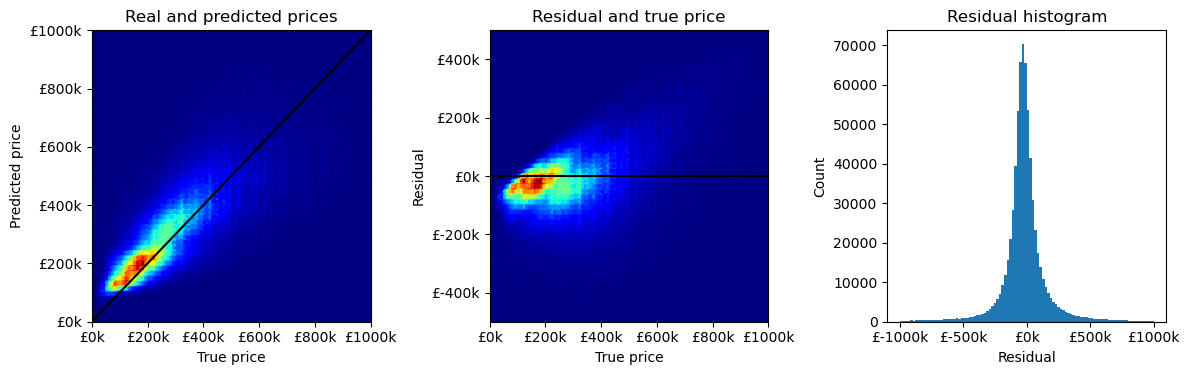

R² = 0.076


In [11]:
#With 55 neighbours
model_2 = clone(knn_model_pipeline)
model_2.set_params(regressor__regressor__n_neighbors=55)
model_2.fit(X_train_subset, y_train_subset)
y_validate_predict = model_2.predict(X_validate)
assess_predict(y_validate, y_validate_predict)

In [12]:
features_to_include = X_train.columns.values
feature_importance = feature_importance_test(model_2, X_train_subset, y_train_subset, X_validate, y_validate)

r2 = 0.076, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: days_since_first

r2 = 0.077, change = -0.001
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: longitude

r2 = 0.076, change = 0.002
features: ['New' 'Tenure' 'latitude' 'gender_ratio' 'child_ratio' 'elderly_ratio'
 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: sine_day

r2 = 0.080, change = -0.004
features: ['New' 'Tenure' 'latitude' 'gender_ratio' 'child_ra

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
feature_importance

,least_important_feature,r2,r2_change
0,days_since_first,0.076,0.000
1,longitude,0.077,-0.001
2,sine_day,0.076,0.002
3,gender_ratio,0.080,-0.004
4,latitude,0.084,-0.004
5,Eng_Wal,0.082,0.002
6,New,0.082,-0.000
7,cosine_day,0.081,0.001
8,Tenure,0.080,0.001
9,elderly_ratio,0.080,0.000


C-2. Tuning hyperparameters 2

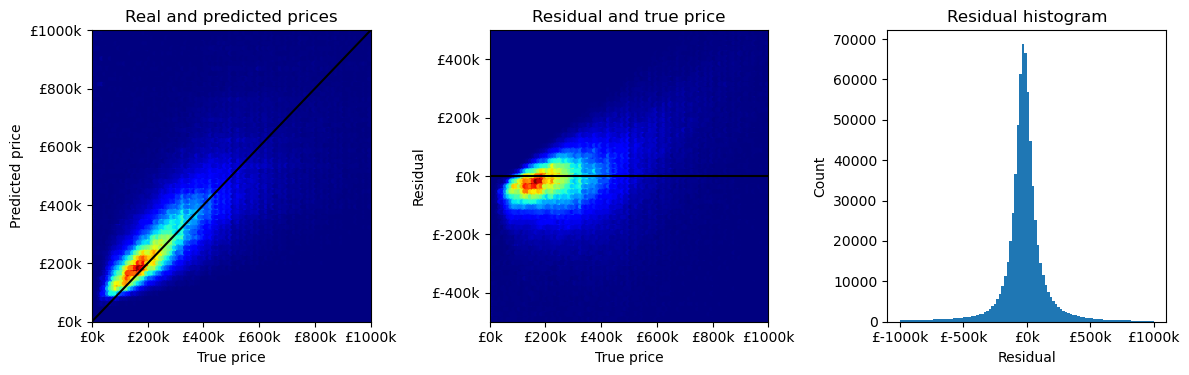

R² = 0.079


In [14]:
features_to_include_2 = [
    'listings_per_capita',
    'London_distance',
    'commute_distance',
    'Type_D',
    'Type_S',
    'Type_T',
    'Type_F',
    'child_ratio',
    'Income'
]

#New model with updated features
model_3 = clone(model_2)


model_3.fit(X_train_subset[features_to_include_2],y_train_subset)
y_validate_predict = model_3.predict(X_validate[features_to_include_2])
assess_predict(y_validate, y_validate_predict)

In [15]:
param_grid_3 = {'regressor__regressor__n_neighbors': [5,15,25,35,45,55,65,75],
              'regressor__regressor__weights': ['uniform', 'distance'],
              'regressor__regressor__leaf_size': [20,30,40,50],
              'regressor__regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'regressor__log_transform__log_income': [True, False],
              'regressor__log_transform__log_listings': [True, False],
              'transformer__log_target': [True, False]}

# randomised search
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_3,
    param_grid_3,
    cv=3,
    scoring='r2',
    n_iter=200,
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train_subset, y_train_subset)

RandomizedSearchCV(cv=3,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                                   LogTransformer()),
                                                                                  ('scaler',
                                                                                   StandardScaler()),
                                                                                  ('regressor',
                                                                                   KNeighborsRegressor(n_neighbors=55))]),
                                                        transformer=ConditionalLogTransformer()),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'regressor__log_transform__log_income': [True,
                                                                                 False],
                                        'regressor__log_transform__log_listings': [True,
                                                                                   False],
                                        'regressor__regressor__algorithm': ['auto',
                                                                            'ball_tree',
                                                                            'kd_tree',
                                                                            'brute'],
                                        'regressor__regressor__leaf_size': [20,
                                                                            30,
                                                                            40,
                                                                            50],
                                        'regressor__regressor__n_neighbors': [5,
                                                                              15,
                                                                              25,
                                                                              35,
                                                                              45,
                                                                              55,
                                                                              65,
                                                                              75],
                                        'regressor__regressor__weights': ['uniform',
                                                                          'distance'],
                                        'transformer__log_target': [True,
                                                                    False]},
                   random_state=89, scoring='r2')

In [17]:
print("Best parameters:", random_search.best_params_)

Best parameters: {'transformer__log_target': False, 'regressor__regressor__weights': 'distance', 'regressor__regressor__n_neighbors': 45, 'regressor__regressor__leaf_size': 30, 'regressor__regressor__algorithm': 'kd_tree', 'regressor__log_transform__log_listings': True, 'regressor__log_transform__log_income': False}


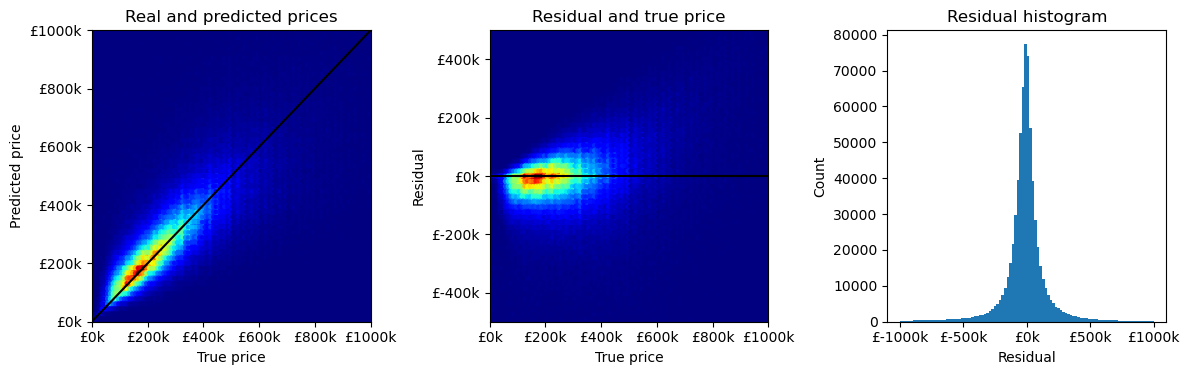

R² = -0.322


In [63]:
#Updated hyperparameters recheck features
model_4 = clone(knn_model_pipeline)
model_4.set_params(
    regressor__regressor__weights='distance', 
    regressor__regressor__n_neighbors=45, 
    regressor__regressor__leaf_size=30, 
    regressor__regressor__algorithm='kd_tree', 
    regressor__log_transform__log_listings=True, 
)

model_4.fit(X_train_subset[features_to_include_2], y_train_subset)
y_validate_predict = model_4.predict(X_validate[features_to_include_2])
assess_predict(y_validate, y_validate_predict)

D-2. Selecting features 2

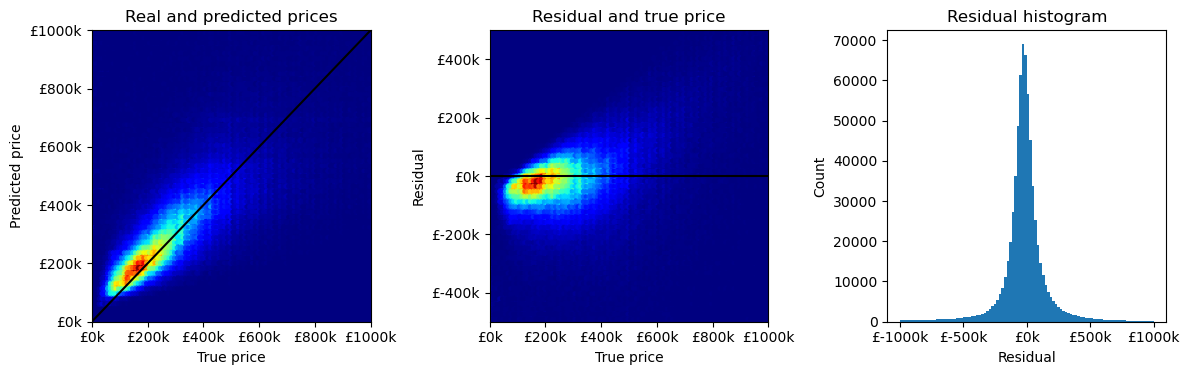

R² = 0.077


In [68]:
#Negative R2. This is overfitting training data. On experimenting, weights='distance' is causing this and it performs reasonably if this is removed
model_5 = clone(knn_model_pipeline)
model_5.set_params(
    #regressor__regressor__weights='distance', 
    regressor__regressor__n_neighbors=45, 
    regressor__regressor__leaf_size=30, 
    regressor__regressor__algorithm='kd_tree', 
    regressor__log_transform__log_listings=True, 
)

model_5.fit(X_train_subset[features_to_include_2], y_train_subset)
y_validate_predict = model_5.predict(X_validate[features_to_include_2])
assess_predict(y_validate, y_validate_predict)

In [70]:
#Continuing with other hyperparmeters tuned in previous search, but keeping weights='uniform'
model_5.fit(X_train_subset, y_train_subset)
features_to_include = X_train.columns.values
feature_importance = feature_importance_test(model_5, X_train_subset, y_train_subset, X_validate, y_validate)

r2 = 0.076, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: days_since_first

r2 = 0.078, change = -0.001
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: gender_ratio

r2 = 0.079, change = -0.001
features: ['New' 'Tenure' 'latitude' 'longitude' 'child_ratio' 'elderly_ratio'
 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: latitude

r2 = 0.079, change = 0.000
features: ['New' 'Tenure' 'longitude' 'child_ratio' 'elderly_

KeyError: 'listings_per_capita'

In [5]:
#Crashed due to log features transformer not working correctly when that column is excluyded from the  fit. Fixed function and set running from where it crashed
model_5 = clone(knn_model_pipeline)
model_5.set_params(
    regressor__regressor__n_neighbors=45, 
    regressor__regressor__leaf_size=30, 
    regressor__regressor__algorithm='kd_tree', 
    regressor__log_transform__log_listings=True)
features_at_restart = ['child_ratio', 'commute_distance', 'Income', 'Type_D', 'Type_F', 'Type_S', 'Type_T']

feature_importance = feature_importance_test(model_5, X_train_subset[features_at_restart], y_train_subset, X_validate[features_at_restart], y_validate)

r2 = 0.063, change = 0.000
features: ['child_ratio' 'commute_distance' 'Income' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: commute_distance

r2 = 0.054, change = 0.009
features: ['child_ratio' 'Income' 'Type_D' 'Type_F' 'Type_S' 'Type_T']
least important feature: Type_D

r2 = 0.041, change = 0.013
features: ['child_ratio' 'Income' 'Type_F' 'Type_S' 'Type_T']
least important feature: Type_S

r2 = 0.032, change = 0.009
features: ['child_ratio' 'Income' 'Type_F' 'Type_T']
least important feature: Type_T

r2 = 0.026, change = 0.006
features: ['child_ratio' 'Income' 'Type_F']
least important feature: Type_F

r2 = 0.007, change = 0.018
features: ['child_ratio' 'Income']
least important feature: child_ratio

r2 = 0.011, change = -0.004
features: ['Income']
least important feature: Income



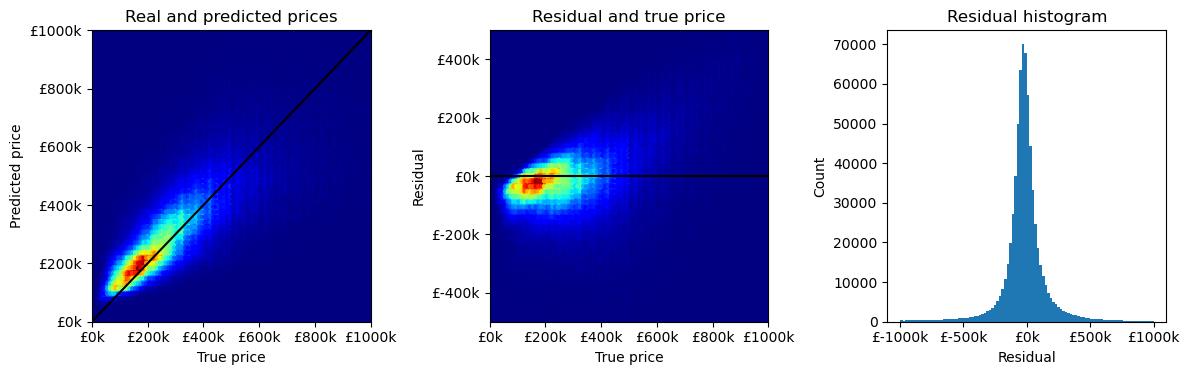

R² = 0.083


In [6]:
#significant features

features_to_include_3 = ['New', 'Tenure', 'longitude', 'child_ratio', 'elderly_ratio',
                         'commute_distance', 'Income', 'London_distance', 'listings_per_capita',
                         'cosine_day', 'Type_D', 'Type_F', 'Type_S', 'Type_T']

model_5.fit(X_train_subset[features_to_include_3], y_train_subset)
y_validate_predict = model_5.predict(X_validate[features_to_include_3])
assess_predict(y_validate, y_validate_predict)

C-3. Tuning hyperparameters 3

In [7]:
param_grid_4 = {'regressor__regressor__n_neighbors': [5,15,25,35,45,55,65,75],
              'regressor__regressor__leaf_size': [20,30,40,50],
              'regressor__regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'regressor__log_transform__log_income': [True, False],
              'regressor__log_transform__log_listings': [True, False],
              'transformer__log_target': [True, False]}

# randomised search
random_search = RandomizedSearchCV(
    model_5,
    param_grid_4,
    cv=3,
    scoring='r2',
    n_iter=100,
    random_state=89,
    n_jobs=-1)

random_search.fit(X_train_subset, y_train_subset)

RandomizedSearchCV(cv=3,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                                   LogTransformer(log_listings=True)),
                                                                                  ('scaler',
                                                                                   StandardScaler()),
                                                                                  ('regressor',
                                                                                   KNeighborsRegressor(algorithm='kd_tree',
                                                                                                       n_neighbors=45))]),
                                                        transformer=ConditionalLogTransformer()),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__log_transform__log_income': [True,
                                                                                 False],
                                        'regressor__log_transform__log_listings': [True,
                                                                                   False],
                                        'regressor__regressor__algorithm': ['auto',
                                                                            'ball_tree',
                                                                            'kd_tree',
                                                                            'brute'],
                                        'regressor__regressor__leaf_size': [20,
                                                                            30,
                                                                            40,
                                                                            50],
                                        'regressor__regressor__n_neighbors': [5,
                                                                              15,
                                                                              25,
                                                                              35,
                                                                              45,
                                                                              55,
                                                                              65,
                                                                              75],
                                        'transformer__log_target': [True,
                                                                    False]},
                   random_state=89, scoring='r2')

In [8]:
print("Best parameters:", random_search.best_params_)

Best parameters: {'transformer__log_target': False, 'regressor__regressor__n_neighbors': 45, 'regressor__regressor__leaf_size': 50, 'regressor__regressor__algorithm': 'kd_tree', 'regressor__log_transform__log_listings': True, 'regressor__log_transform__log_income': False}


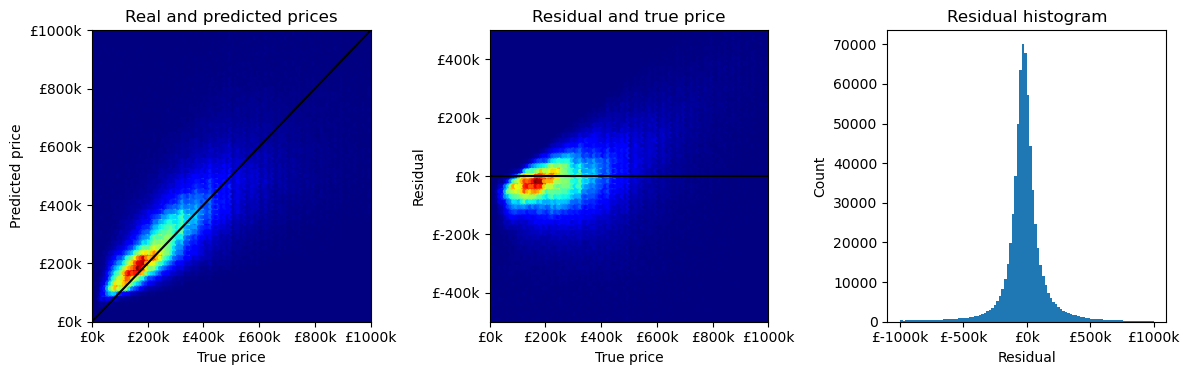

R² = 0.083


In [6]:
model_6 = clone(knn_model_pipeline)
model_6.set_params(
    regressor__regressor__n_neighbors=45, 
    regressor__regressor__leaf_size=50, 
    regressor__regressor__algorithm='kd_tree', 
    regressor__log_transform__log_listings=True, 
)
#Leaf size 40->50. Othwerwise the same as previous hyperparameters. Almost converged.

model_6.fit(X_train_subset[features_to_include_3], y_train_subset)
y_validate_predict = model_6.predict(X_validate[features_to_include_3])
assess_predict(y_validate, y_validate_predict)

D-3. Selecting features 3

In [7]:
feature_importance = feature_importance_test(model_6, X_train_subset, y_train_subset, X_validate, y_validate)

r2 = 0.076, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: days_since_first

r2 = 0.078, change = -0.001
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: gender_ratio

r2 = 0.079, change = -0.001
features: ['New' 'Tenure' 'latitude' 'longitude' 'child_ratio' 'elderly_ratio'
 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'sine_day' 'cosine_day' 'Type_D' 'Type_F' 'Type_S'
 'Type_T']
least important feature: latitude

r2 = 0.079, change = 0.000
features: ['New' 'Tenure' 'longitude' 'child_ratio' 'elderly_

In [8]:
feature_importance

,least_important_feature,r2,r2_change
0,days_since_first,0.076399,0.000000
1,gender_ratio,0.077703,-0.001304
2,latitude,0.079110,-0.001407
3,sine_day,0.078669,0.000442
4,Eng_Wal,0.083446,-0.004777
5,longitude,0.083416,0.000030
6,New,0.082264,0.001152
7,cosine_day,0.081810,0.000454
8,Tenure,0.081506,0.000304
9,elderly_ratio,0.078415,0.003090


In [19]:
important_features_3 = [
    'Tenure','child_ratio','elderly_ratio','commute_distance','Income',
     'London_distance','listings_per_capita','Type_D','Type_F','Type_S',
     'Type_T'
]
#Exact same features as second optimisation
#Convergance reached

E. Training final model and saving output

In [20]:
#Prepare final model

#Optimised hyperparameters
knn_model_final = clone(knn_model_pipeline).set_params(
    regressor__regressor__n_neighbors=45, 
    regressor__regressor__leaf_size=50, 
    regressor__regressor__algorithm='kd_tree', 
    regressor__log_transform__log_listings=True, 
)

#Optimised features
important_feautures_final = [
    'Tenure',
    'child_ratio',
    'elderly_ratio',
    'commute_distance',
    'Income',
     'London_distance',
    'listings_per_capita',
    'Type_D',
    'Type_F',
    'Type_S',
     'Type_T'
]

In [21]:
knn_model_final.fit(X_train_all[important_feautures_final], y_train_all)

TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                      LogTransformer(log_listings=True)),
                                                     ('scaler',
                                                      StandardScaler()),
                                                     ('regressor',
                                                      KNeighborsRegressor(algorithm='kd_tree',
                                                                          leaf_size=50,
                                                                          n_neighbors=45))]),
                           transformer=ConditionalLogTransformer())

In [24]:
#Fetch test data
raw_test_df = pd.read_csv('test_house_final.csv')

#Numerically encode categorical features
test_df_encode = encode_categories(raw_test_df)

#Split train dataset into X (features) and y (targets)
X_test = test_df_encode.drop('Price', axis=1)
y_test = test_df_encode['Price']

X_test.shape, y_test.shape

((523267, 19), (523267,))

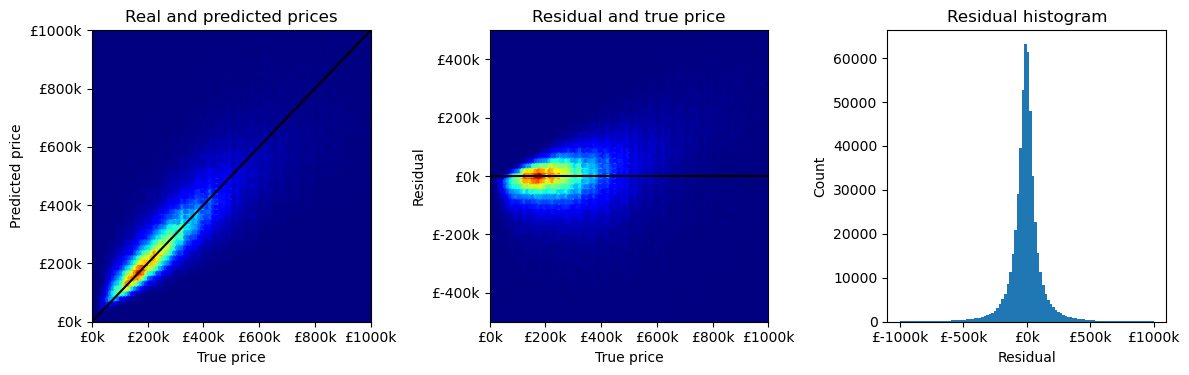

R² = 0.062


In [25]:
#Predict prices of test data
y_test_pred_final = knn_model_final.predict(X_test[important_feautures_final])

#Check fit
assess_predict(y_test, y_test_pred_final)

In [26]:
#Save final fit to csv
final_fit = pd.DataFrame({
    'True_Price': y_test,
    'KNN_Prediction': y_test_pred_final
})
final_fit.to_csv('test_results\\knn_model.csv', index_label='Index', float_format='%.2f')